In [13]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [22]:
file_path = 'dataset/data.csv'

# Load the dataset
data = pd.read_csv(file_path)

# Display the first few rows of the dataset to confirm it's loaded correctly
print(data.head())

data.info()


                  date      price  bedrooms  bathrooms  sqft_living  sqft_lot  \
0  2014-05-02 00:00:00   313000.0       3.0       1.50         1340      7912   
1  2014-05-02 00:00:00  2384000.0       5.0       2.50         3650      9050   
2  2014-05-02 00:00:00   342000.0       3.0       2.00         1930     11947   
3  2014-05-02 00:00:00   420000.0       3.0       2.25         2000      8030   
4  2014-05-02 00:00:00   550000.0       4.0       2.50         1940     10500   

   floors  waterfront  view  condition  sqft_above  sqft_basement  yr_built  \
0     1.5           0     0          3        1340              0      1955   
1     2.0           0     4          5        3370            280      1921   
2     1.0           0     0          4        1930              0      1966   
3     1.0           0     0          4        1000           1000      1963   
4     1.0           0     0          4        1140            800      1976   

   yr_renovated                    str

In [23]:
data.isnull().sum()


date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
street           0
city             0
statezip         0
country          0
dtype: int64

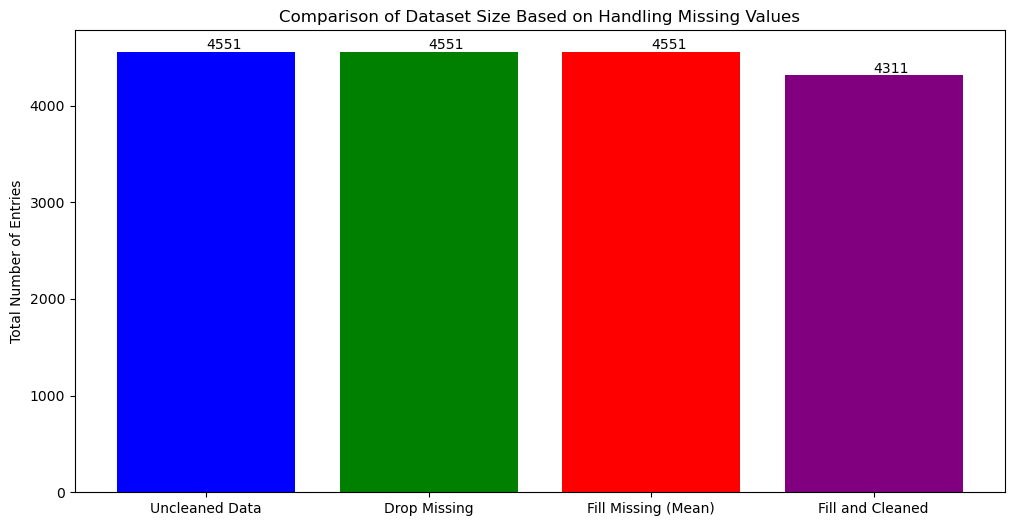

In [24]:
# Convert 'date' to datetime
data['date'] = pd.to_datetime(data['date'])

#remove where price is 0
data = data[data['price'] != 0]

# Initial total count
initial_count = len(data)

# Handle missing values by dropping them
data_dropna = data.dropna()
dropna_count = len(data_dropna)

# Handle missing values by filling them with the mean for numerical columns
data_fillmean = data.copy()
for column in ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 
               'waterfront', 'view', 'condition', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated']:
    data_fillmean[column] = data_fillmean[column].fillna(data_fillmean[column].mean())
fillmean_count = len(data_fillmean)

# Feature Engineering
data_fillmean['house_age'] = 2023 - data_fillmean['yr_built']  # Assuming current year is 2023
data_fillmean['years_since_renovation'] = data_fillmean.apply(
    lambda row: 2023 - row['yr_renovated'] if row['yr_renovated'] > 0 else 0, axis=1)
data_fillmean['total_sqft'] = data_fillmean['sqft_living'] + data_fillmean['sqft_lot']
data_fillmean['price_per_sqft'] = data_fillmean['price'] / data_fillmean['sqft_living']
data_fillmean['bed_to_bath_ratio'] = data_fillmean['bedrooms'] / data_fillmean['bathrooms']

# Remove duplicates and outliers after filling missing values
data_fillmean = data_fillmean.drop_duplicates()
q1 = data_fillmean['price'].quantile(0.25)
q3 = data_fillmean['price'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
data_fillmean = data_fillmean[(data_fillmean['price'] >= lower_bound) & (data_fillmean['price'] <= upper_bound)]

# Final count after all cleaning steps for filled mean data
final_fillmean_count = len(data_fillmean)

# Plotting the results
plt.figure(figsize=(12, 6))
bar_locations = ['Uncleaned Data', 'Drop Missing', 'Fill Missing (Mean)', 'Fill and Cleaned']
counts = [initial_count, dropna_count, fillmean_count, final_fillmean_count]
bars = plt.bar(bar_locations, counts, color=['blue', 'green', 'red', 'purple'])

# Adding the exact counts above the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval}', va='bottom')  # va: vertical alignment

plt.ylabel('Total Number of Entries')
plt.title('Comparison of Dataset Size Based on Handling Missing Values')
plt.show()

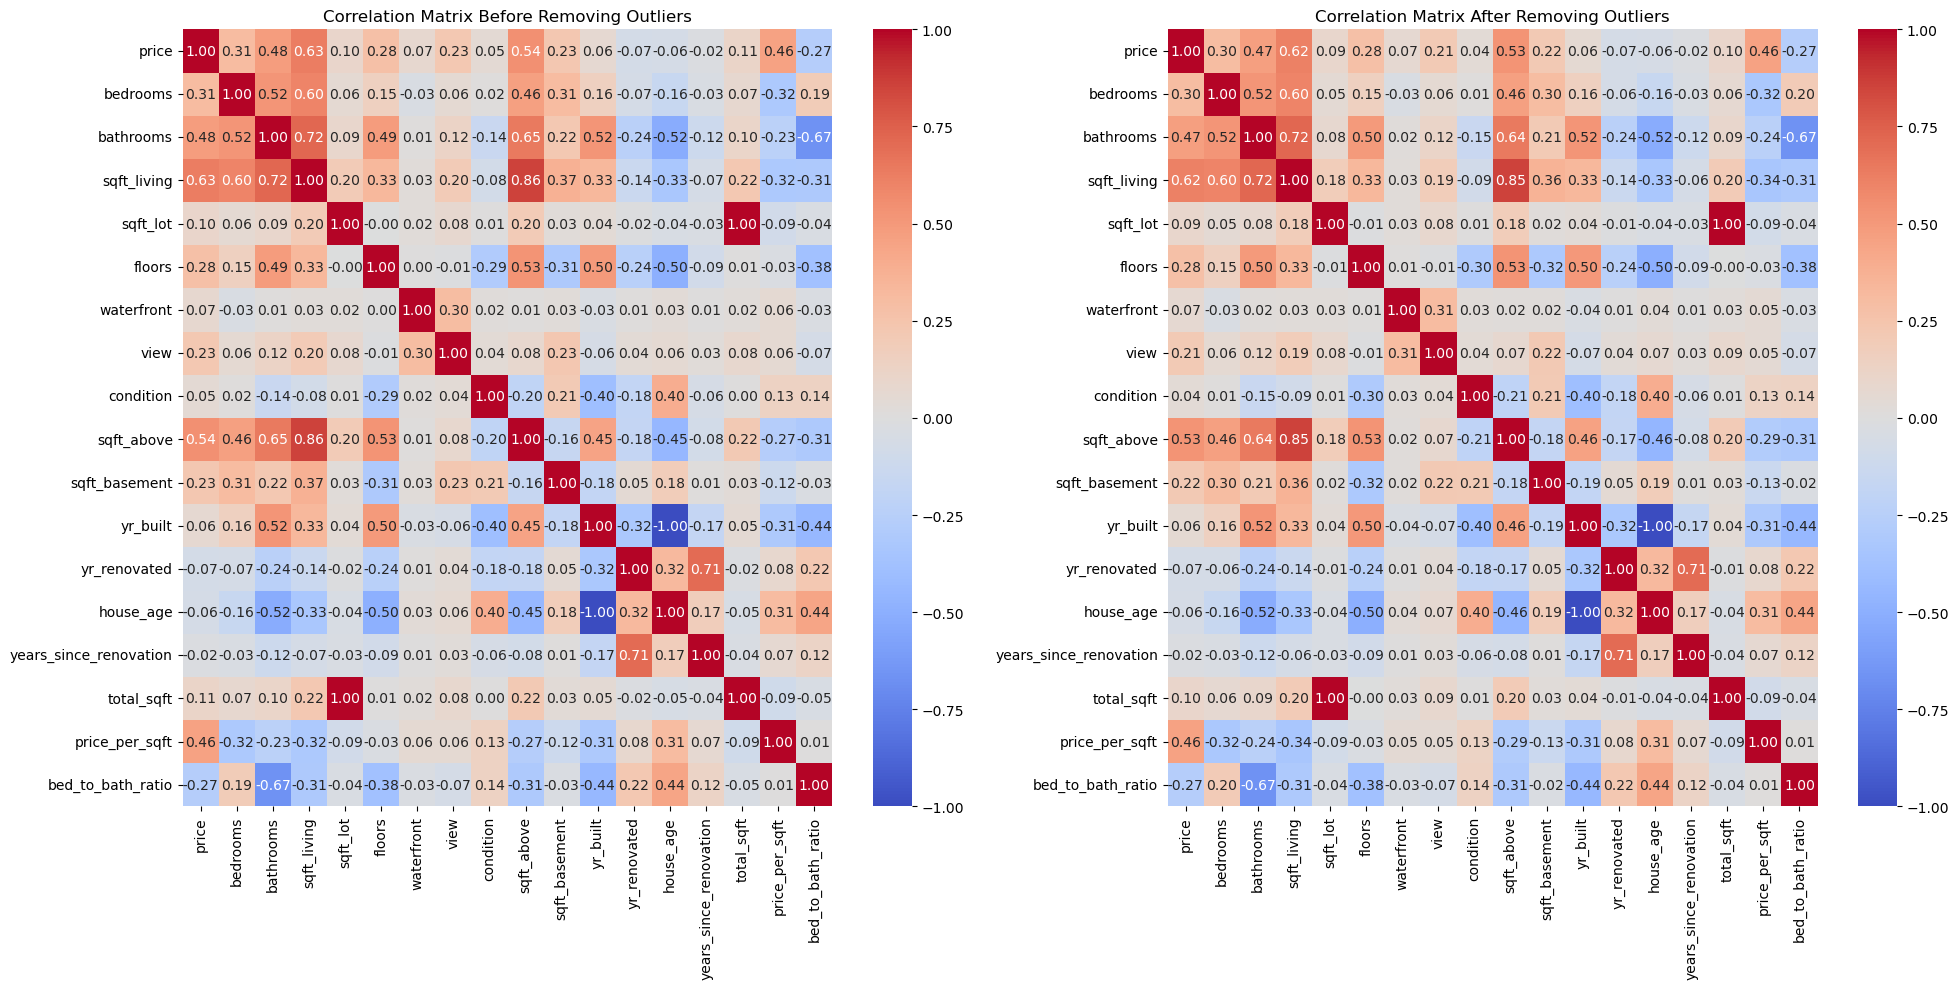

In [25]:
# Update list of numerical columns to include new features
numerical_columns = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 
                     'waterfront', 'view', 'condition', 'sqft_above', 'sqft_basement', 
                     'yr_built', 'yr_renovated', 'house_age', 'years_since_renovation', 
                     'total_sqft', 'price_per_sqft', 'bed_to_bath_ratio']

# Handling missing values by filling them with the mean for numerical columns
for column in numerical_columns:
    data_fillmean[column] = data_fillmean[column].fillna(data_fillmean[column].mean())

# Removing duplicates
data_fillmean = data_fillmean.drop_duplicates()

# Storing data before removing outliers
data_before_outliers = data_fillmean.copy()

# Identifying and removing outliers in 'price'
q1 = data_fillmean['price'].quantile(0.25)
q3 = data_fillmean['price'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
data_fillmean = data_fillmean[(data_fillmean['price'] >= lower_bound) & (data_fillmean['price'] <= upper_bound)]

# Creating heatmaps for all numerical columns
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
sns.heatmap(data_before_outliers[numerical_columns].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Before Removing Outliers')

plt.subplot(1, 2, 2)
sns.heatmap(data_fillmean[numerical_columns].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix After Removing Outliers')

plt.tight_layout()
plt.show()

In [27]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

# Assuming 'data_fillmean' is your DataFrame after cleaning and outlier removal
# Selecting the numerical columns you wish to analyze
numerical_columns = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 
                     'waterfront', 'view', 'condition', 'sqft_above', 'sqft_basement', 
                     'yr_built', 'yr_renovated', 'house_age', 'years_since_renovation', 
                     'total_sqft', 'price_per_sqft', 'bed_to_bath_ratio']

# Dropping 'price' as it is the dependent variable
X = data_fillmean[numerical_columns]

# Adding a constant to the independent variables (important for VIF calculation)
X = sm.add_constant(X)

# Calculating VIF for each feature
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Displaying the VIF for each feature
print(vif_data.sort_values('VIF', ascending=False))


                   feature        VIF
9               sqft_above        inf
10           sqft_basement        inf
3              sqft_living        inf
4                 sqft_lot        inf
15              total_sqft        inf
13               house_age        inf
11                yr_built        inf
2                bathrooms  10.346828
17       bed_to_bath_ratio   6.579365
1                 bedrooms   5.321081
12            yr_renovated   2.643056
14  years_since_renovation   2.112860
5                   floors   2.010314
8                condition   1.490262
16          price_per_sqft   1.320778
7                     view   1.212664
6               waterfront   1.113976
0                    const   0.000000


c:\Users\hkhat\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\hkhat\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'floors',
       'waterfront', 'view', 'condition', 'sqft_basement', 'yr_renovated',
       'street', 'city', 'statezip', 'country', 'house_age',
       'years_since_renovation', 'price_per_sqft', 'bed_to_bath_ratio'],
      dtype='object')


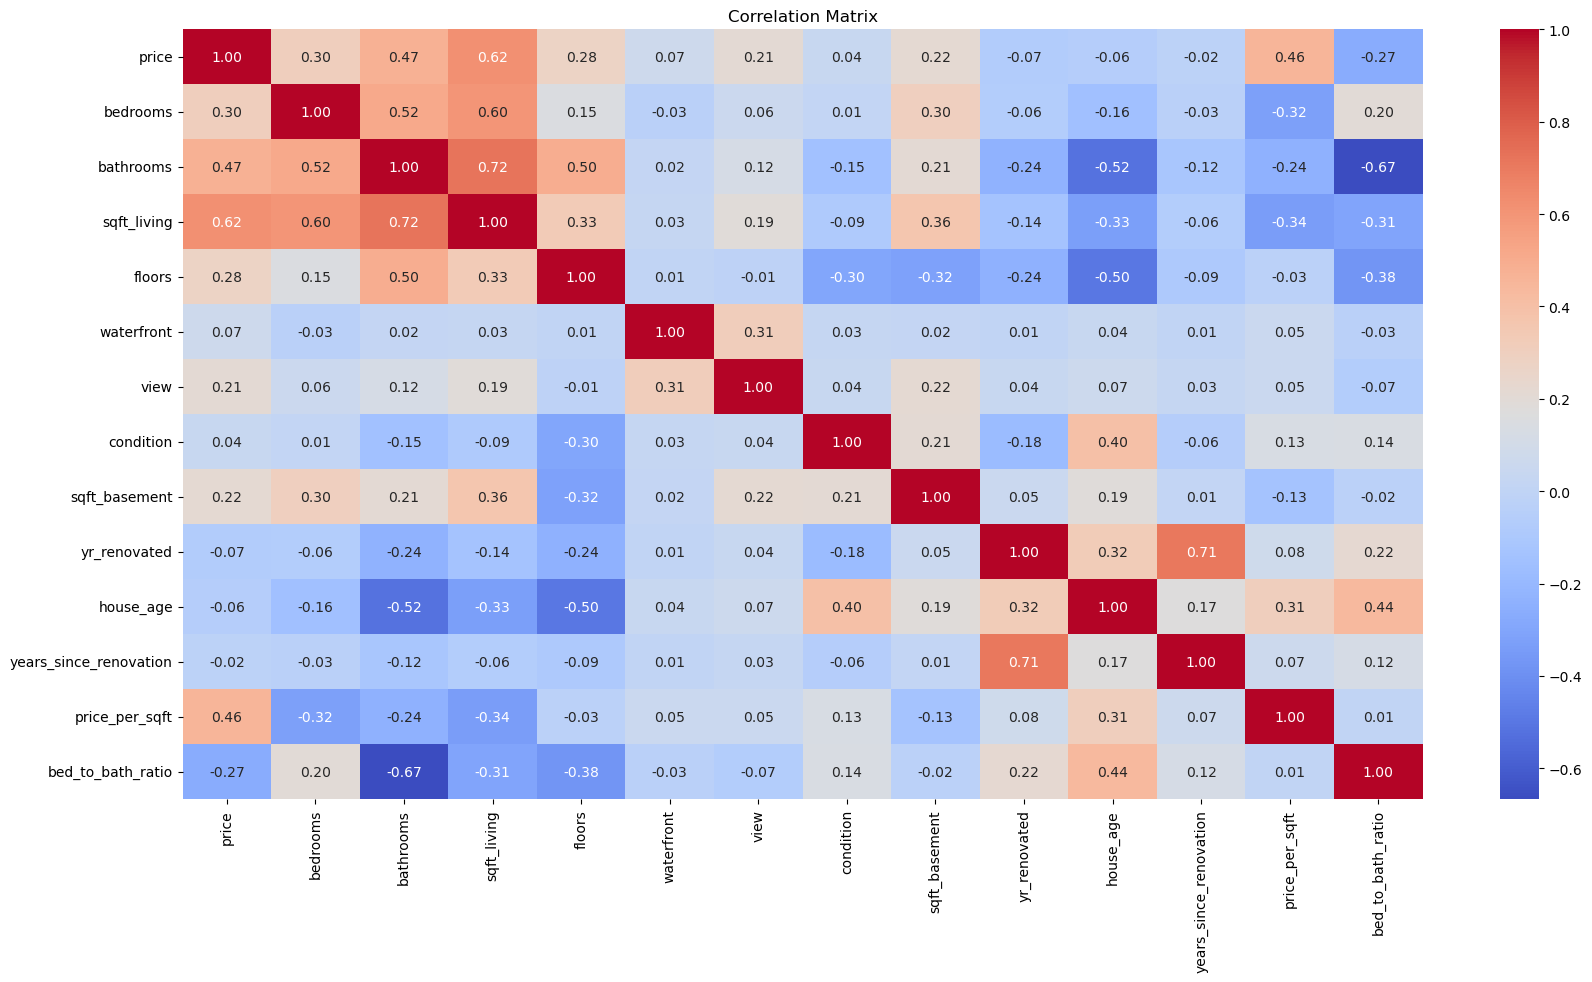

In [28]:
# List of columns to drop based on analysis
columns_to_drop = [
    'sqft_above',  # High VIF with sqft_living
    'yr_built',    # Redundant with house_age
    'sqft_lot',    # Typically less impact on price
    'total_sqft',  # Likely redundant with sqft_living
    # Retaining 'waterfront' and 'view' as they could significantly affect price despite low variability
    # 'years_since_renovation' and 'yr_renovated' could be considered if they don't contribute to model accuracy
]

# Remove the unnecessary columns
data_fillmean = data_fillmean.drop(columns=columns_to_drop, errors='ignore')

# Check the remaining columns to ensure they are dropped
print(data_fillmean.columns)

# Save the cleaned dataset
data_fillmean.to_csv('dataset/cleaned_data.csv', index=False)
numerical_columns = data_fillmean.select_dtypes(include=['number']).columns
data_numeric = data_fillmean[numerical_columns]

# Creating heatmap for correlation matrix
plt.figure(figsize=(20, 10))
sns.heatmap(data_numeric.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()



Analysis


Variables like sqft_above and sqft_living often exhibit high multicollinearity because sqft_above is part of the total sqft_living. You should check the VIF for these variables.

yr_built and house_age can be redundant since house_age is derived from yr_built.

total_sqft might be highly correlated with sqft_living and sqft_above.

The features waterfront, view, and yr_renovated may have a lot of zeros (indicating most houses don't have these features or haven't been renovated), which could skew their influence in a typical linear regression model unless properly transformed or handled.

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'floors',
       'condition', 'sqft_above', 'sqft_basement', 'street', 'city',
       'statezip', 'price_per_sqft'],
      dtype='object')


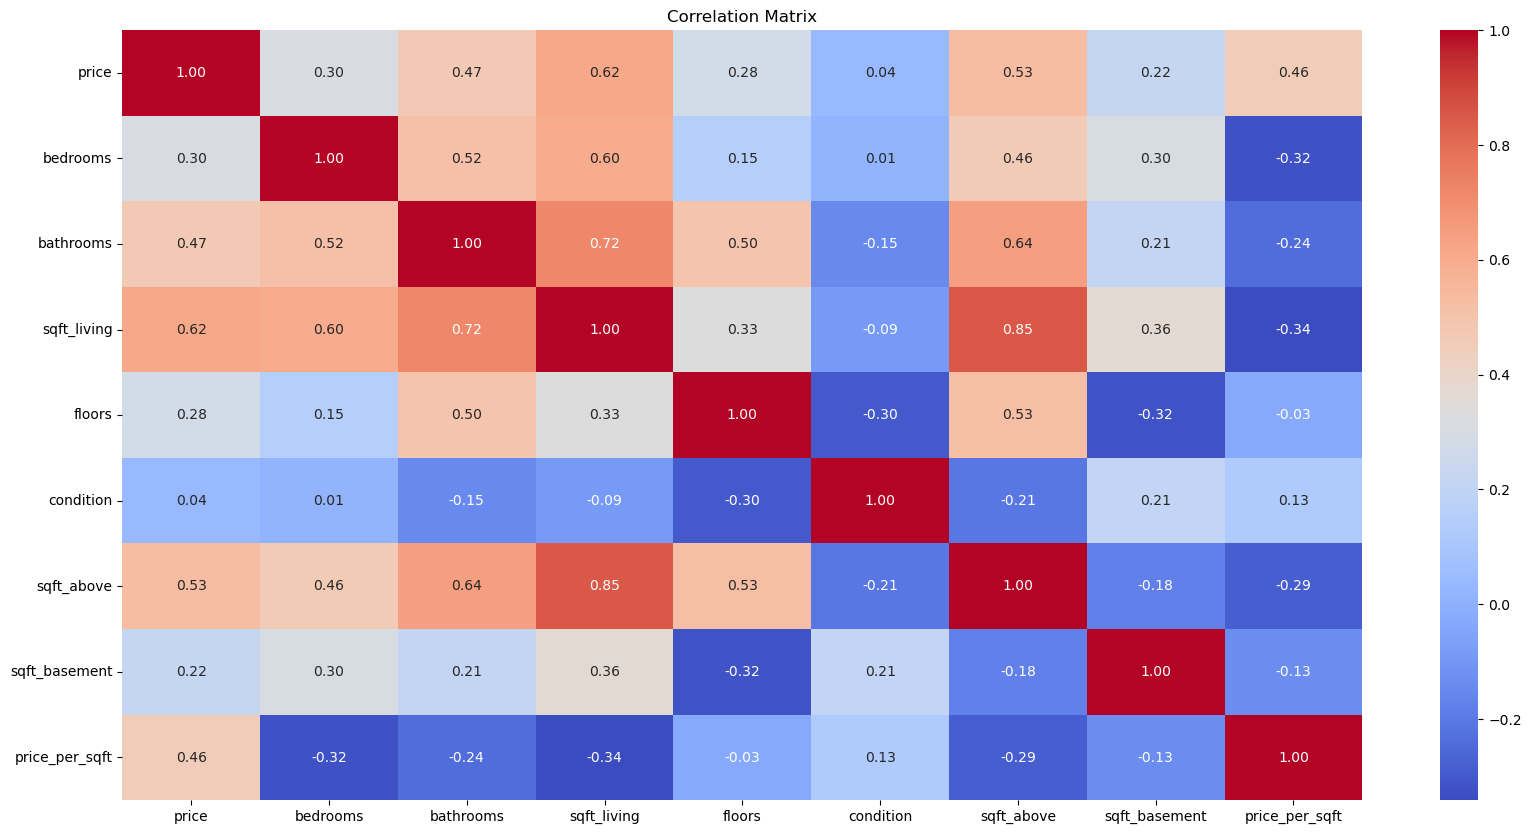

In [20]:
# List of columns to drop based on  analysis (provided in readme.md)
columns_to_drop = [
    'house_age', 'total_sqft', 'bed_to_bath_ratio'
]

# Remove the unnecessary columns
data_fillmean = data_fillmean.drop(columns=columns_to_drop, errors='ignore')

# Check the remaining columns to ensure they are dropped
print(data_fillmean.columns)

# Save the cleaned dataset
data_fillmean.to_csv('dataset/cleaned_data.csv', index=False)
numerical_columns = data_fillmean.select_dtypes(include=['number']).columns
data_numeric = data_fillmean[numerical_columns]

# Creating heatmap for correlation matrix
plt.figure(figsize=(20, 10))
sns.heatmap(data_numeric.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()